In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
import elevation
import elevation.prediction_pipeline as pp
from IPython.core.debugger import Tracer
import matplotlib.pyplot as plt
np.random.seed(123) 
import scipy.stats as st
import pickle
#import seaborn
import matplotlib
import azimuth.util

In [15]:
colors = ['#ca0020', '#f4a582', '#ffffbf', '#92c5de', '#0571b0']
background_color = '#EAEAF2'

plt.rcParams['xtick.labelsize'] = 17
plt.rcParams['ytick.labelsize'] = 17
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 17
plt.rcParams['font.family'] = 'Segoe UI'
plt.rcParams['xtick.major.size'] = 0
plt.rcParams['xtick.minor.size'] = 0
plt.rcParams['ytick.major.size'] = 0
plt.rcParams['ytick.minor.size'] = 0
plt.rcParams['axes.edgecolor'] = 'white'

methods_colors = {'CFD': '#f4a582',
                 'HsuZhang': '#92c5de',
                 'CCTOP': "#0571b0",
                 'Elevation': '#ca0020',
                 'Elevation DNASE': '#caff20',
                 'Elevation-naive': '#92c5de'}

methods_names = {'CFD': 'CFD',
                'HsuZhang': 'HsuZhang',
                'CCTOP': 'CCTOP',
                'ensemble': 'Elevation',
                'ensemble_dnase': 'Elevation DNASE',
                'product': 'Elevation-naive'}

In [3]:
np.random.seed(123)
learn_options = {'num_proc': 10,
                     'nuc_features_WT': False, 'include_pi_nuc_feat': False,
                     'annotation position one-hot': False,
                     'mutation_type' : False,
                     'annotation_onehot' : True, # featurize like CFD
                     'annotation_decoupled_onehot' : ['pos', 'let', 'transl'], # decouple the CFD features into letters and position                    
                     "include_Tm": False,
                     'include_azimuth_score': None, # all of them ["WT","MUT","DELTA"]
                     'azimuth_feat' : None, # was: ['WT']
                     "include_gene_position": False,
                     "cv": "stratified",
                     'adaboost_loss' : 'ls',
                     'adaboost_CV': False, "algorithm_hyperparam_search" : "grid",
                     'n_folds' : 10,
                     'allowed_category' : None,#"Mismatch",#"Insertion",
                     "include_NGGX_interaction": False,
                     'normalize_features' : False, 'class_weight': None,
                     "phen_transform": 'kde_cdf', #  'kde_cdf',
                     "training_metric": 'spearmanr',
                     "fit_intercept" : True,
                     "seed" : 12345,
                     "num_proc": 1,
                     "alpha": np.array([1.0e-3]),
                     "V": "CD33", 
                     "left_right_guide_ind": [4,27,30], # 21-mer
                     "order": 1,
                     "testing_non_binary_target_name": 'ranks',
                     'models': ["AdaBoost"],
                     'post-process Platt': False,
                     'azimuth_score_in_stacker': False,
                     'guide_seq_full': True,
                     'use_mut_distances': False,
                     'reload guideseq': False,
                     "renormalize_guideseq": True,
}

# Pickling 

In [4]:
base_model, fnames = pp.train_base_model(learn_options) 
guideseq_data = pp.load_guideseq(learn_options, filterPAMs=False, subsample_zeros=False) 

hmg = elevation.load_data.load_hauessler_minus_guideseq()
hmg['GUIDE-SEQ Reads'] = hmg['readFraction'].copy()

preds_guideseq = pp.predict_guideseq(base_model, guideseq_data, learn_options,  naive_bayes_combine=True)
#with open('../elevation/guideseq_all_zeros_pred.pickle', 'rb') as f:
#    preds_guideseq, learn_options_p = pickle.load(f)
   
nb_pred_hmg, individual_mut_pred_hmg = pp.predict(base_model, hmg, learn_options)
# with open('/tmp/trainhu_gs.pickle', 'rb') as f:
#      individual_mut_pred_hmg = pickle.load(f)
    
roc_data, roc_Y_bin, roc_Y_vals = elevation.load_data.load_HauesslerFig2();
nb_pred_roc, individual_mut_pred_roc = pp.predict(base_model, roc_data, learn_options)

cd33_data = elevation.load_data.load_cd33(learn_options)[0]
cd33_data['Annotation'] = cd33_data['Annotation'].apply(lambda x: [x])

# with open('../elevation/calibration_models.pickle', 'rb') as f:
#    calibration_models = pickle.load(f)

TypeError: run_models() got an unexpected keyword argument 'test'

In [ ]:
to_be_calibrated = ['product', 'linear-raw-stacker', 'ensemble']
calibration_models = {}

for m in to_be_calibrated:
    calibration_models[m] = pp.train_prob_calibration_model(cd33_data, guideseq_data, preds_guideseq, 
                                                            base_model, learn_options, which_model=m,
                                                            other_calibration_models=calibration_models)

with open('../elevation/calibration_models.pickle', 'wb') as f:
    pickle.dump(calibration_models, f)

In [8]:
# Melih's Additions

In [6]:
from elevation.cmds.predict import Predict
predict_inst = Predict()

Time spent loading pickles:  15.1589999199


In [7]:
learn_options = predict_inst.learn_options
base_model = predict_inst.base_model

guideseq_data = predict_inst.guideseq_data
preds_guideseq = predict_inst.preds_guideseq

roc_data, roc_Y_bin, roc_Y_vals = elevation.load_data.load_HauesslerFig2();
nb_pred_roc, individual_mut_pred_roc = pp.predict(base_model, roc_data, learn_options)

In [32]:
print "train", "test"
print guideseq_data['30mer_mut'].shape, roc_data['30mer_mut'].shape
print len(set(map(lambda x: x[:20], guideseq_data['30mer'].unique()))), roc_data['30mer'].unique().shape
print len(guideseq_data['30mer'].iloc[0]), len(roc_data['30mer'].iloc[0])
print len("GACCCCCTCCACCCCGCCTCCGG"), len("AAATGAGAAGAAGAGGCACAAGG")

train test
(294664L,) (26052L,)
9 (27L,)
23 23
23 23


In [33]:
for i in sorted(set(map(lambda x: x[:20], guideseq_data['30mer'].unique()))):
    print i

GAACACAAAGCATAGACTGC
GACCCCCTCCACCCCGCCTC
GAGTCCGAGCAGAAGAAGAA
GGAATCCCTTCTGCAGCACC
GGCACTGCGGCTGGAGGTGG
GGCCCAGACTGAGCACGTGA
GGGAAAGACCCAGCATCCGT
GGGTGGGGGGAGTTTGCTCC
GGTGAGTGAGTGTGTGCGTG


In [ ]:
# for annotations, search for hf_6mm

# Train on Guide-seq predict on Haeussler

In [9]:
pred_roc_calibrated, stacker_gs, feat_gs = pp.stacked_predictions(roc_data, individual_mut_pred_roc, learn_options=learn_options, 
                                       guideseq_data=guideseq_data,
                                       preds_guideseq=preds_guideseq, 
                                       prob_calibration_model=None,#calibration_models,
                                       models=['product', 'linear-raw-stacker', 'CFD', 'HsuZhang', 'CCTOP', 'ensemble', 'ensemble_dnase'],
                                       return_model=True)

C:\Users\v-huelib\AppData\Local\Continuum\Anaconda2\envs\elevation\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\Users\v-huelib\AppData\Local\Continuum\Anaconda2\envs\elevation\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


product
HsuZhang
CCTOP
CFD
linear-raw-stacker
ensemble


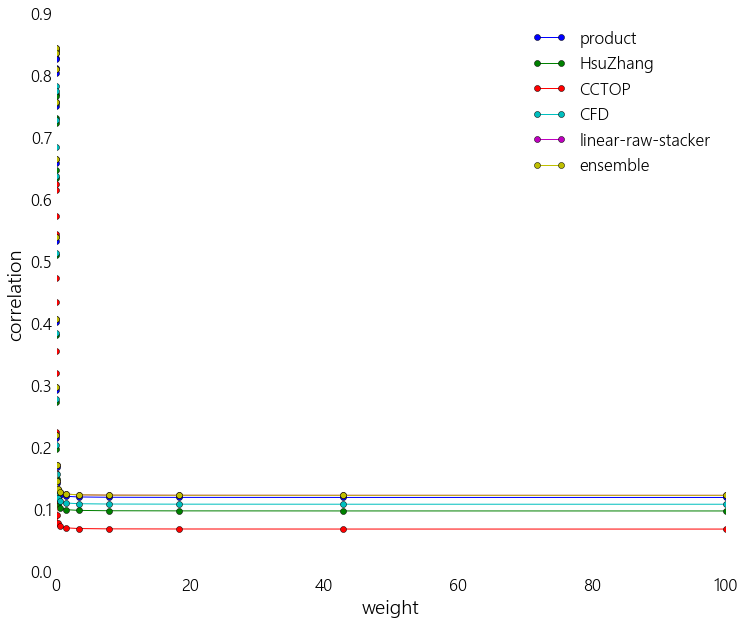

In [10]:
roc_results = pp.plot_spearman_with_different_weights(pred_roc_calibrated, roc_Y_vals.values.flatten(), 
                                                      weights=np.logspace(np.log10(0.00001), np.log10(100), 20))

In [11]:
import elevation.metrics

def pv_weighted_spearman(pred1, pred2, truth, weights):
    pvs = []
    for w in weights:
        weights_array = truth.copy()
        weights_array += w
        pv = elevation.metrics.spearman_weighted_swap_perm_test(pred1, pred2, truth, 10, weights_array)[0]
        pvs.append(pv)
    return pvs

#roc_pvs = pv_weighted_spearman(pred_roc_calibrated['ensemble'], 
#                               pred_roc_calibrated['CFD'], 
#                               roc_Y_vals.values.flatten(),  
#                               weights=np.logspace(np.log10(0.00001), np.log10(100), 1))

In [13]:
with open('roc.pickle', 'wb') as f:
    pickle.dump((pred_roc_calibrated, roc_Y_vals), f)

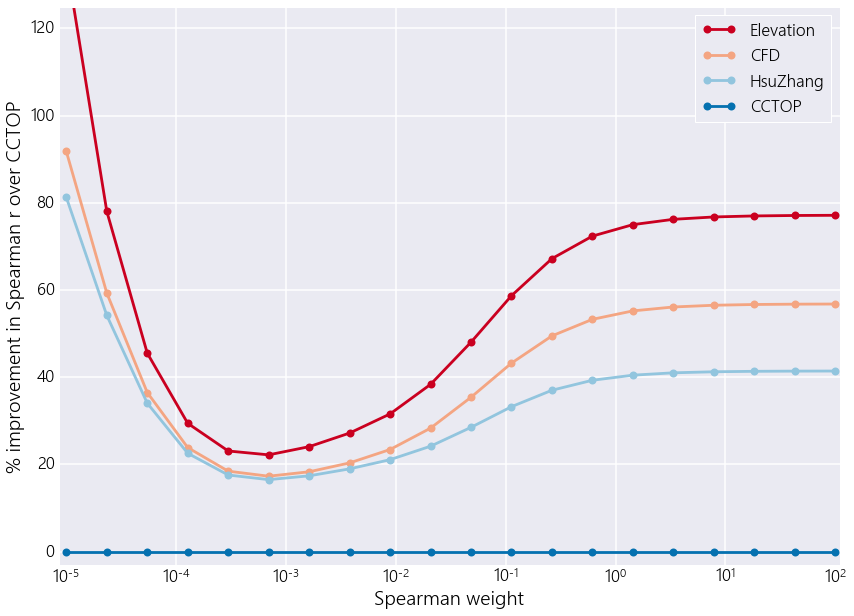

In [14]:
fig = plt.figure(figsize=(14, 10))

x = np.logspace(np.log10(0.00001), np.log10(100), 20)
for m in ['ensemble', 'ensemble_dnase', 'CFD', 'HsuZhang', 'CCTOP']:
    plt.plot(x, ((np.array(roc_results[m]) -np.array(roc_results['CCTOP']))/np.array(roc_results['CCTOP']))*100., 'o-', 
             label=methods_names[m], color=methods_colors[methods_names[m]], markeredgewidth=0.0, linewidth=2.8, markersize=8)
plt.xscale('log')

# background color
ax = plt.gca()
ax.patch.set_facecolor(background_color)

# grid
plt.grid(color='#ffffff', linestyle='-', linewidth=1.5)
ax.set_axisbelow(True)
a = ax.get_xgridlines()
a[2].set_color(background_color)
a[-1].set_color(background_color)


# legend
plt.legend(loc=0)
lh = ax.get_legend()
lh.legendPatch.set_facecolor(background_color)


plt.ylim(-3., 125)
x_lims = plt.xlim()
plt.xlim((8.5e-6, 1.10*x_lims[1]))

plt.ylabel('% improvement in Spearman r over CCTOP')
plt.xlabel('Spearman weight')
plt.savefig('plots/improvement_over_CCTOP_Haeussler.pdf')
# plt.title("Haeussler minus GUIDE-Seq")

In [ ]:
fig = plt.figure(figsize=(14, 10))

x = np.logspace(np.log10(0.00001), np.log10(100), 20)
for m in ['ensemble', 'CFD', 'HsuZhang', 'CCTOP', 'linear-raw-stacker']:
    plt.plot(x, ((np.array(roc_results[m]) -np.array(roc_results['CCTOP']))/np.array(roc_results['CCTOP']))*100., 'o-', 
             label=m, markeredgewidth=0.0, linewidth=2.8, markersize=8)
plt.xscale('log')

# background color
ax = plt.gca()
ax.patch.set_facecolor(background_color)

# grid
plt.grid(color='#ffffff', linestyle='-', linewidth=1.5)
ax.set_axisbelow(True)
a = ax.get_xgridlines()
a[2].set_color(background_color)
a[-1].set_color(background_color)


# legend
plt.legend(loc=0)
lh = ax.get_legend()
lh.legendPatch.set_facecolor(background_color)


plt.ylim(-3., 140)
x_lims = plt.xlim()
plt.xlim((8.5e-6, 1.10*x_lims[1]))

plt.ylabel('% improvement in Spearman r over CCTOP')
plt.xlabel('Spearman weight')
plt.savefig('plots/improvement_over_CCTOP_Haeussler.pdf')
# plt.title("Haeussler minus GUIDE-Seq")

# Train on Haeussler predict on Guide-seq

In [139]:
pred_guideseq_hmg, stacker_hmg, feat_hmg = pp.stacked_predictions(guideseq_data, preds_guideseq, guideseq_data=hmg,
                                            preds_guideseq=individual_mut_pred_hmg,
                                            prob_calibration_model=None,
                                            learn_options=learn_options,
                                            models=['product', 'linear-raw-stacker', 'CFD', 'HsuZhang', 'CCTOP', 'ensemble'],
                                            return_model=True,
                                            )

In [ ]:
gs_results_hmg = pp.plot_spearman_with_different_weights(pred_guideseq_hmg, guideseq_data['GUIDE-SEQ Reads'].values.flatten(), 
                                                      weights=np.logspace(np.log10(0.00001), np.log10(100), 20))

product
HsuZhang
CCTOP
CFD
linear-raw-stacker

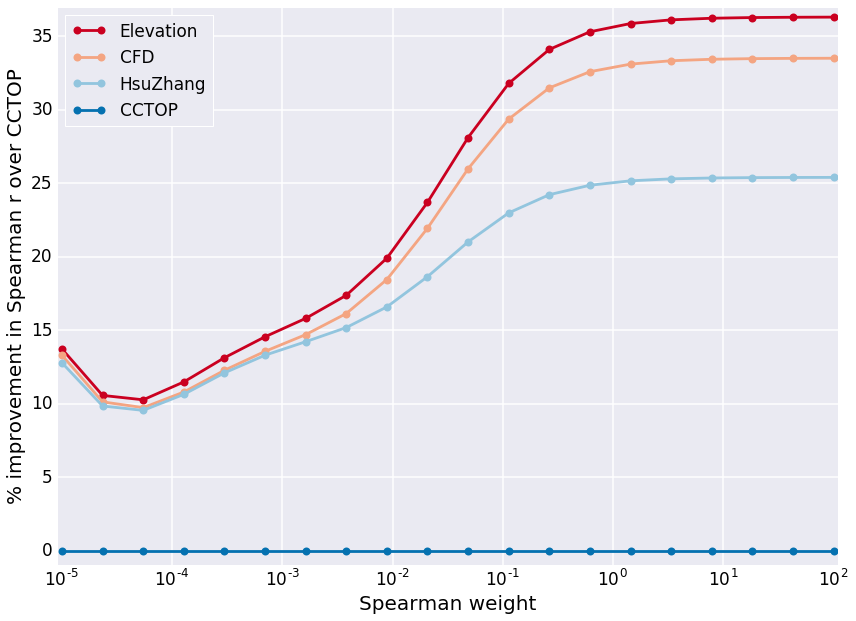

In [11]:
fig = plt.figure(figsize=(14, 10))

x = np.logspace(np.log10(0.00001), np.log10(100), 20)
for m in ['ensemble', 'CFD', 'HsuZhang', 'CCTOP']:
    plt.plot(x, ((np.array(gs_results_hmg[m]) -np.array(gs_results_hmg['CCTOP']))/np.array(gs_results_hmg['CCTOP']))*100., 'o-', 
             label=methods_names[m], color=methods_colors[methods_names[m]], markeredgewidth=0.0, linewidth=2.8, markersize=8)
plt.xscale('log')

# background color
ax = plt.gca()
ax.patch.set_facecolor(background_color)

# grid
plt.grid(color='#ffffff', linestyle='-', linewidth=1.5)
ax.set_axisbelow(True)
a = ax.get_xgridlines()
a[2].set_color(background_color)
a[-1].set_color(background_color)
# legend
plt.legend(loc=0)
lh = ax.get_legend()
lh.legendPatch.set_facecolor(background_color)


plt.ylim(-0.95, 37)
x_lims = plt.xlim()
plt.xlim((9.0e-6, 1.10*x_lims[1]))

plt.ylabel('% improvement in Spearman r over CCTOP')
plt.xlabel('Spearman weight')

plt.savefig('plots/improvement_over_CCTOP_Guideseq_trainingonHaeussler.pdf')

# Cross-validation on Guide-seq

In [222]:
pred_gs, perf_gs, mismatches_gs, truth_gs, _, _ = pp.cross_validate_guideseq(guideseq_data,
                                                                            preds_guideseq,
                                                                            learn_options,
       models= ['CFD', 'HsuZhang', 'CCTOP', 'product', 'linear-raw-stacker', 'ensemble'], n_folds=20)

predictions_flat = dict([(k, np.concatenate(pred_gs[k]).flatten()) for k in pred_gs.keys()])
truth_all = np.concatenate(truth_gs).flatten()

Loading CFD table from file
Fold 1, Spearman r: product=0.059 HsuZhang=0.058 CCTOP=0.047 CFD=0.059 linear-raw-stacker=0.060 ensemble=0.060 
Fold 1, NDCG k ties: product=0.637 HsuZhang=0.559 CCTOP=0.517 CFD=0.466 linear-raw-stacker=0.648 ensemble=0.548 
Loading CFD table from file
Fold 2, Spearman r: product=0.058 HsuZhang=0.053 CCTOP=0.048 CFD=0.059 linear-raw-stacker=0.059 ensemble=0.060 
Fold 2, NDCG k ties: product=0.750 HsuZhang=0.980 CCTOP=0.553 CFD=0.342 linear-raw-stacker=0.750 ensemble=0.672 
Loading CFD table from file
Fold 3, Spearman r: product=0.058 HsuZhang=0.057 CCTOP=0.040 CFD=0.059 linear-raw-stacker=0.059 ensemble=0.059 
Fold 3, NDCG k ties: product=0.526 HsuZhang=0.744 CCTOP=0.727 CFD=0.320 linear-raw-stacker=0.528 ensemble=0.778 
Loading CFD table from file
Fold 4, Spearman r: product=0.055 HsuZhang=0.053 CCTOP=0.048 CFD=0.058 linear-raw-stacker=0.058 ensemble=0.058 
Fold 4, NDCG k ties: product=0.254 HsuZhang=0.849 CCTOP=0.253 CFD=0.398 linear-raw-stacker=0.282 ense

product
HsuZhang
CCTOP
CFD
linear-raw-stacker
ensemble


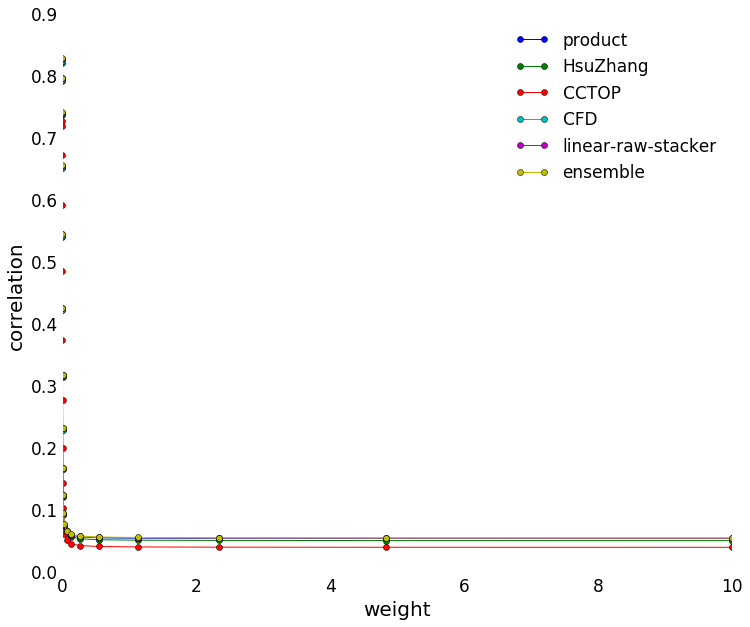

In [226]:
gs_results = pp.plot_spearman_with_different_weights(predictions_flat, truth_all, 
                                                      weights=np.logspace(np.log10(0.00001), np.log10(10), 20))

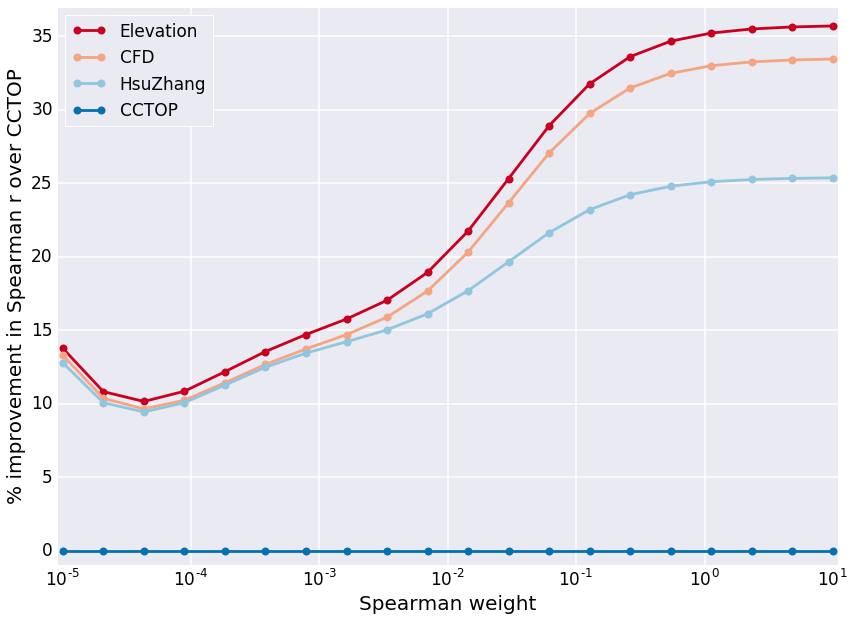

In [229]:
fig = plt.figure(figsize=(14, 10))

x = np.logspace(np.log10(0.00001), np.log10(10), 20)
for m in ['ensemble', 'CFD', 'HsuZhang', 'CCTOP']:
    plt.plot(x, ((np.array(gs_results[m]) -np.array(gs_results['CCTOP']))/np.array(gs_results['CCTOP']))*100., 'o-', 
             label=methods_names[m], color=methods_colors[methods_names[m]], markeredgewidth=0.0, linewidth=2.8, markersize=8)
plt.xscale('log')

# background color
ax = plt.gca()
ax.patch.set_facecolor(background_color)

# grid
plt.grid(color='#ffffff', linestyle='-', linewidth=1.5)
ax.set_axisbelow(True)
a = ax.get_xgridlines()
a[2].set_color(background_color)
a[-1].set_color(background_color)
# legend
plt.legend(loc=0)
lh = ax.get_legend()
lh.legendPatch.set_facecolor(background_color)


plt.ylim(-0.95, 37)
x_lims = plt.xlim()
plt.xlim((9.0e-6, 1.10*x_lims[1]))

plt.ylabel('% improvement in Spearman r over CCTOP')
plt.xlabel('Spearman weight')

plt.savefig('plots/improvement_over_CCTOP_Guideseq.pdf')

Loading CFD table from file
Fold 1, Spearman r: product=0.044 HsuZhang=0.055 CCTOP=0.045 CFD=0.058 linear-raw-stacker=0.058 ensemble=0.058 
Fold 1, NDCG k ties: product=0.350 HsuZhang=0.443 CCTOP=0.282 CFD=0.265 linear-raw-stacker=0.436 ensemble=0.632 
Loading CFD table from file
Fold 2, Spearman r: product=0.044 HsuZhang=0.052 CCTOP=0.040 CFD=0.057 linear-raw-stacker=0.057 ensemble=0.057 
Fold 2, NDCG k ties: product=0.602 HsuZhang=0.387 CCTOP=0.368 CFD=0.369 linear-raw-stacker=0.686 ensemble=0.714 
Loading CFD table from file
Fold 3, Spearman r: product=0.046 HsuZhang=0.052 CCTOP=0.039 CFD=0.057 linear-raw-stacker=0.057 ensemble=0.057 
Fold 3, NDCG k ties: product=0.267 HsuZhang=0.446 CCTOP=0.324 CFD=0.415 linear-raw-stacker=0.413 ensemble=0.482 
Loading CFD table from file
Fold 4, Spearman r: product=0.046 HsuZhang=0.055 CCTOP=0.044 CFD=0.058 linear-raw-stacker=0.056 ensemble=0.058 
Fold 4, NDCG k ties: product=0.285 HsuZhang=0.329 CCTOP=0.239 CFD=0.245 linear-raw-stacker=0.363 ense

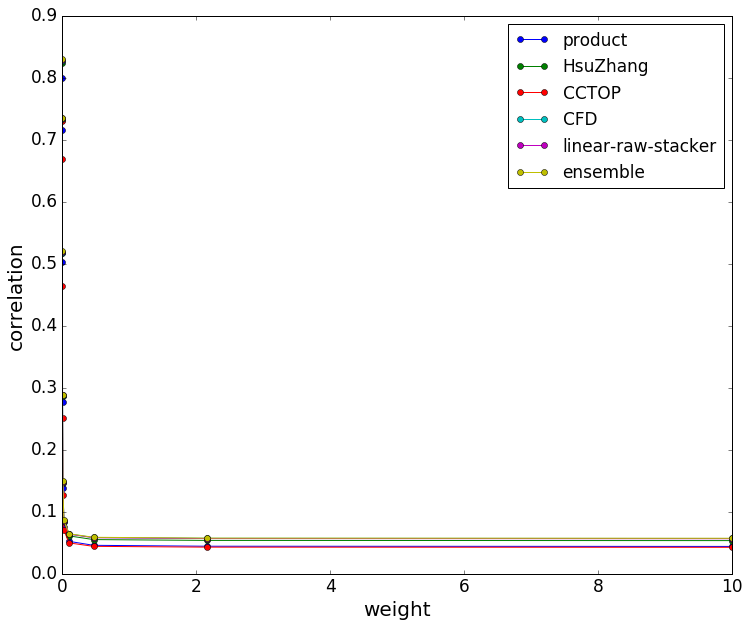

In [108]:
pred_gs_cd33hsu, perf_gs, mismatches_gs, truth_gs_cd33hsu, _, _ = pp.cross_validate_guideseq(guideseq_data,
                                                                            preds_guideseq_cd33hsu,
                                                                            learn_options,
       models= ['CFD', 'HsuZhang', 'CCTOP', 'product', 'linear-raw-stacker', 'ensemble'], n_folds=5)

predictions_flat_cd33hsu = dict([(k, np.concatenate(pred_gs_cd33hsu[k]).flatten()) for k in pred_gs_cd33hsu.keys()])
truth_all_cd33hsu = np.concatenate(truth_gs_cd33hsu).flatten()
gs_results_cd33hsu = pp.plot_spearman_with_different_weights(predictions_flat_cd33hsu, truth_all_cd33hsu, 
                                                      weights=np.logspace(np.log10(0.00001), np.log10(10), 10))

# Base model feature importances

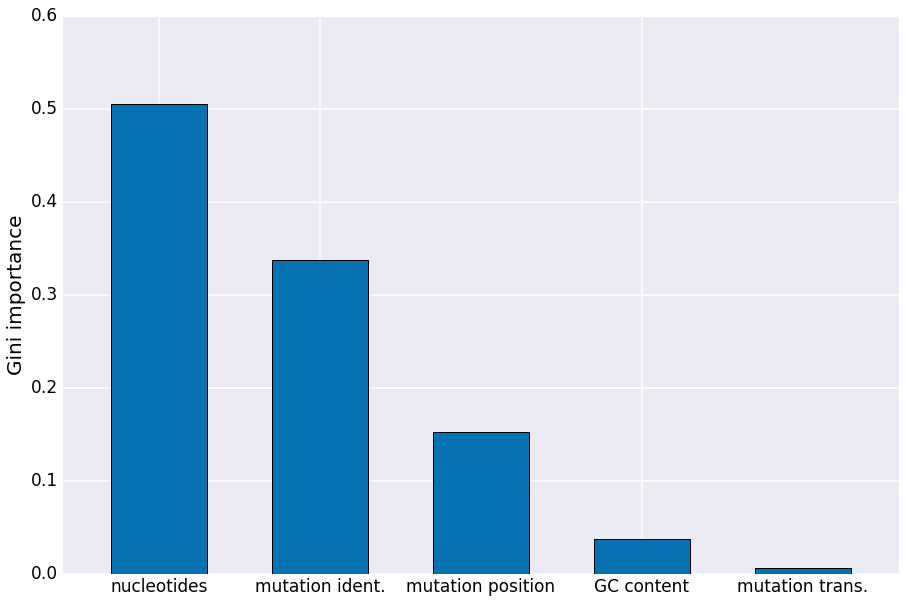

In [46]:
base_feature_names = fnames
feat = pd.DataFrame(index=base_feature_names, data=base_model.feature_importances_, columns=['Gini importance'])
feat_sorted = feat.sort_values(axis=0, ascending=False, by='Gini importance')
feat_sorted_filt = feat_sorted[feat_sorted['Gini importance'] > 0]

feat_sorted.to_excel('plots/base_model_feature_importances.xls')

feature_groups = {'nucleotides': [],
                  'mutation ident.': [],
                  'mutation position': [],
                  'mutation trans.': [],
                  'GC content': []}

for f in feat_sorted_filt.index:
    if ":" in f:
        feature_groups['mutation ident.'].append(f)
    elif "pos" in f:
        feature_groups['mutation position'].append(f)
    elif "_" in f:
        feature_groups['nucleotides'].append(f)
    elif "GC " in f:
        feature_groups['GC content'].append(f)
    elif 'trans' in f or 'translation' in f:
        feature_groups['mutation trans.'].append(f)
    else: # it's a PAM
        feature_groups['mutation ident.'].append(f)
        
names, values = [], []
for fg in feature_groups.keys():
    names.append(fg)
    values.append(feat_sorted_filt.loc[feature_groups[fg]].sum().values[0])

ind = np.argsort(values)[::-1]
names = np.array(names)[ind]
values = np.array(values)[ind]
# plt.style.use(['seaborn-darkgrid', 'seaborn-paper'])
# plt.style.use(['fivethirtyeight'])
plt.figure(figsize=(15, 10))
w = 0.6
plt.ylabel('Gini importance')
plt.bar(np.arange(len(values))+w, values, w,  color=methods_colors['CCTOP'])
plt.xticks(np.arange(len(values))+w+w/2, names, rotation=0)
plt.xlim((0.3, 5.5))

ax = plt.gca()
ax.patch.set_facecolor(background_color)
plt.grid(color='#ffffff', linestyle='-', linewidth=1.5)
ax.set_axisbelow(True)
a = ax.get_xgridlines()
a[2].set_color(background_color)
a[-1].set_color(background_color)


plt.savefig('plots/base_feature_importances.pdf')

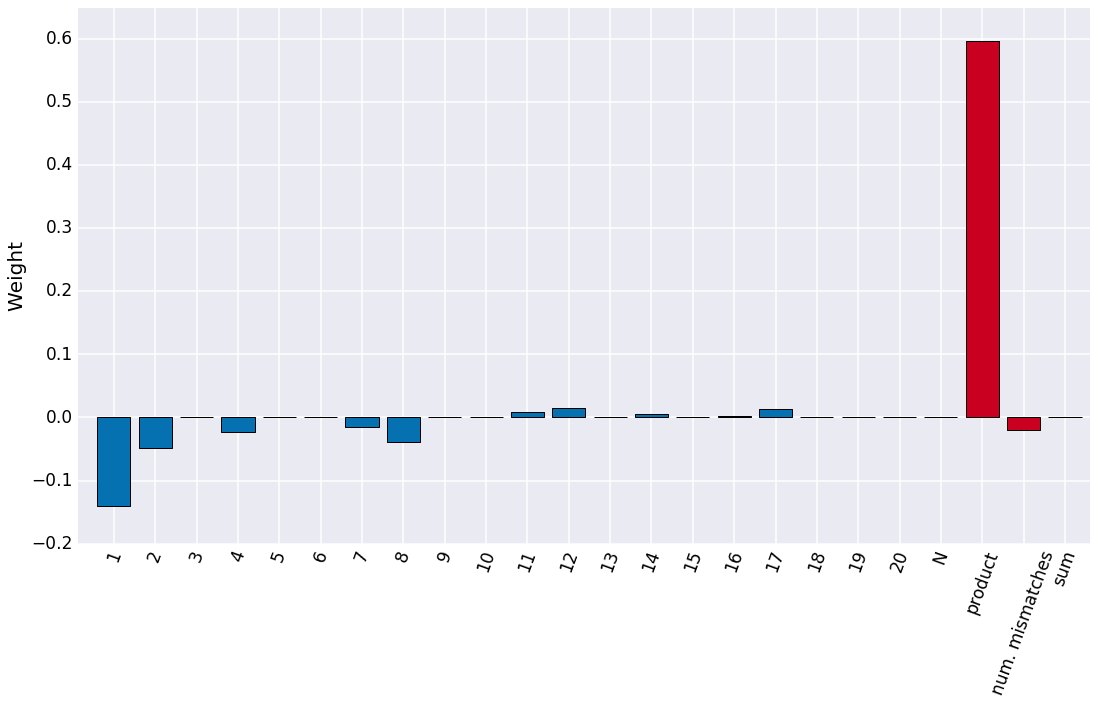

In [44]:
plt.figure(figsize=(15, 10))
coef = stacker_hmg.coef_
coef_hmg = coef

meta_coef = coef[-3:]
nucl_coef = coef[:-3]

names = []
for n in feat_hmg:
    if 'pos' in n:
        l = n.replace('pos', '')
        if l == '21':
            l = 'N'
        names.append(l)
    elif 'annotations' in n:
        names.append(n.replace('annotations', 'mismatches'))
    else:
        names.append(n)
        
ind = np.arange(len(coef))
width = 0.8
plt.bar(ind[:-3], nucl_coef, width, color=methods_colors['CCTOP'])
plt.bar(ind[-3:], meta_coef, width, color=methods_colors['Elevation'])
plt.xticks(ind+width/2., names, rotation=70)
#bbox_inches='tight'
plt.tight_layout()
plt.ylabel('Weight')
#plt.xticks(ind[-3:]+width/2., names[-3:], rotation=80)
plt.xlim((-0.5, 24))
plt.ylim((-0.2, 0.65))

# background color
ax = plt.gca()
ax.patch.set_facecolor(background_color)
plt.grid(color='#ffffff', linestyle='-', linewidth=1.5)
ax.set_axisbelow(True)
a = ax.get_xgridlines()
#a[2].set_color(background_color)
#a[-1].set_color(background_color)
plt.savefig('plots/stacker_feat_importances_train_Haeussler.pdf')

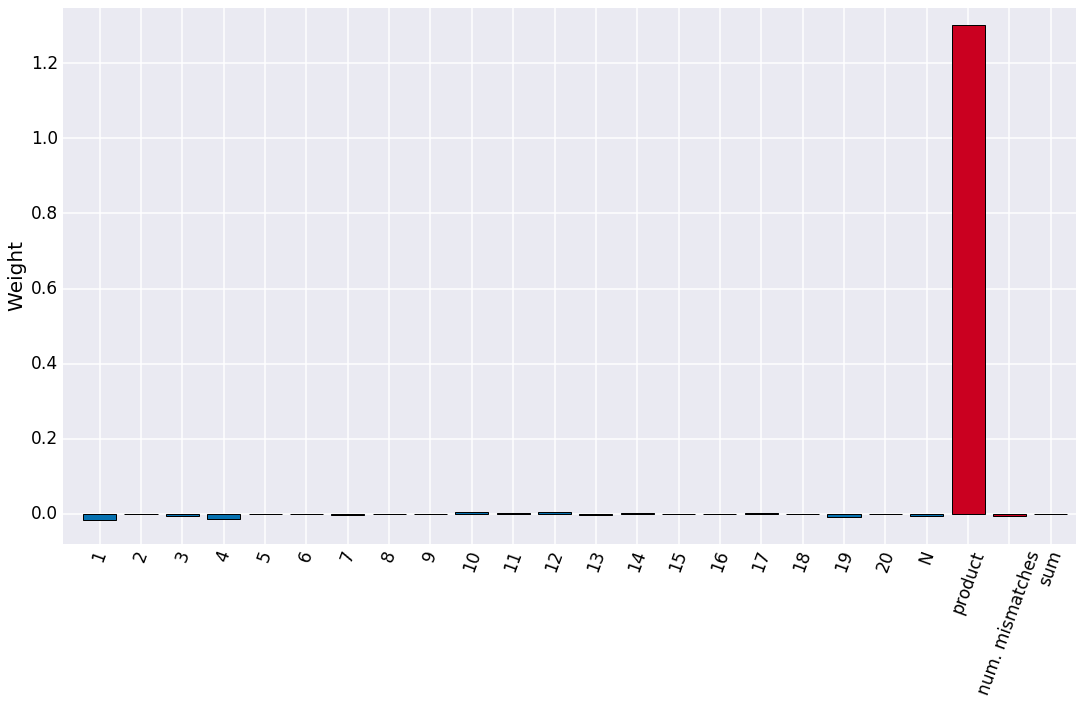

In [45]:
plt.figure(figsize=(15, 10))
coef = stacker_gs.coef_
coef_gs = coef

meta_coef = coef[-3:]
nucl_coef = coef[:-3]

names = []
for n in feat_gs:
    if 'pos' in n:
        l = n.replace('pos', '')
        if l == '21':
            l = 'N'
        names.append(l)
    elif 'annotations' in n:
        names.append(n.replace('annotations', 'mismatches'))
    else:
        names.append(n)
        
ind = np.arange(len(coef))
width = 0.8
plt.bar(ind[:-3], nucl_coef, width, color=methods_colors['CCTOP'])
plt.bar(ind[-3:], meta_coef, width, color=methods_colors['Elevation'])
plt.xticks(ind+width/2., names, rotation=70)
#bbox_inches='tight'
plt.tight_layout()
plt.ylabel('Weight')
#plt.xticks(ind[-3:]+width/2., names[-3:], rotation=80)
plt.xlim((-0.5, 24))
plt.ylim((-0.08, 1.35))
ax = plt.gca()
ax.patch.set_facecolor(background_color)
plt.grid(color='#ffffff', linestyle='-', linewidth=1.5)
ax.set_axisbelow(True)
a = ax.get_xgridlines()
#a[2].set_color(background_color)
#a[-1].set_color(background_color)
plt.savefig('plots/stacker_feat_importances_train_Guideseq.pdf')

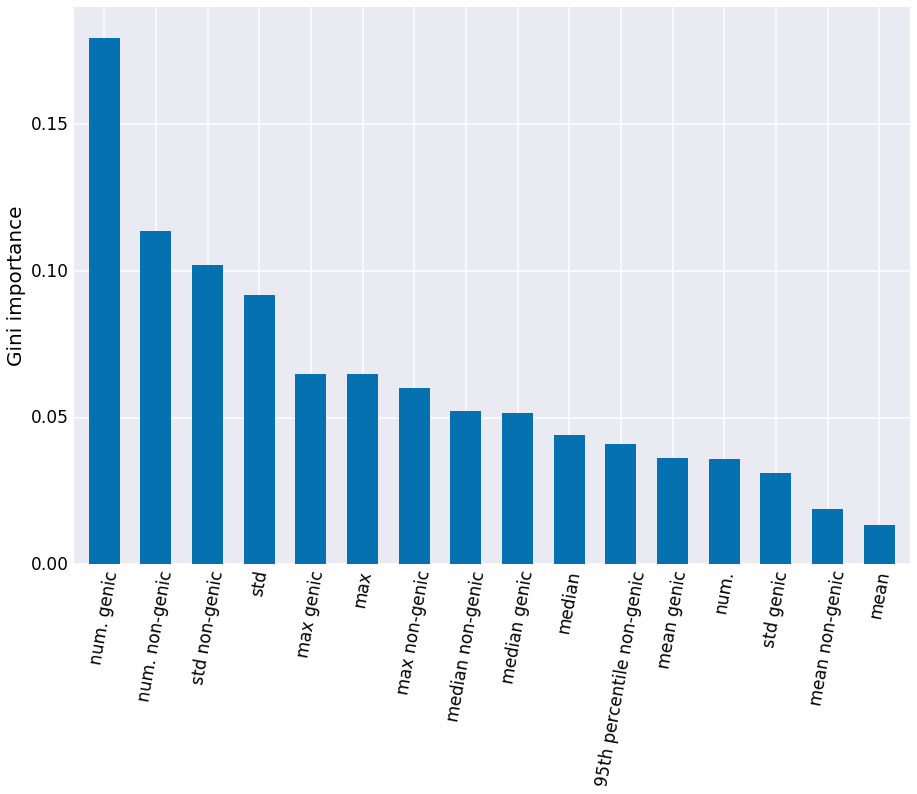

In [49]:
with open('../elevation/aggregation_model.pkl', 'rb') as f:
    aggregator_model = pickle.load(f)

feature_names = ['mean', 'mean genic', 'mean non-genic', 'std', 'std genic', 'std non-genic',
                'num.', 'num. genic', 'num. non-genic',
                'max', 'max genic', 'max non-genic', '95th percentile', '95th percentile genic', '95th percentile non-genic',
                'median', 'median genic', 'median non-genic']

feat = pd.DataFrame(index=feature_names, data=aggregator_model.feature_importances_, columns=['Gini importance'])
feat_sorted = feat.sort_values(axis=0, ascending=False, by='Gini importance')
feat_sorted_filt = feat_sorted[feat_sorted['Gini importance'] > 0]

feat_sorted.to_excel('plots/aggregator_model_feature_importances.xls')

feature_groups = {'nucleotides': [],
                  'mutation ident.': [],
                  'mutation position': [],
                  'mutation trans.': [],
                  'GC content': []}

names, values = [], []
for f in feat_sorted_filt.index:
    names.append(f)
    values.append(feat_sorted_filt.loc[f].values[0])


ind = np.argsort(values)[::-1]
names = np.array(names)[ind]
values = np.array(values)[ind]
# plt.style.use(['seaborn-darkgrid', 'seaborn-paper'])
# plt.style.use(['fivethirtyeight'])
plt.figure(figsize=(15, 10))
w = 0.6
plt.ylabel('Gini importance')
plt.bar(np.arange(len(values))+w, values, w, color=methods_colors['CCTOP'], edgecolor='none')
plt.xticks(np.arange(len(values))+w+w/2, names, rotation=80)

plt.xlim((0.3, 16.5))
plt.ylim((0.0, 0.19))
ax = plt.gca()
ax.patch.set_facecolor(background_color)
plt.grid(color='#ffffff', linestyle='-', linewidth=1.5)
ax.set_axisbelow(True)
a = ax.get_xgridlines()
#a[2].set_color(background_color)
#a[-1].set_color(background_color)
plt.savefig('plots/aggregator_feature_importances.pdf')

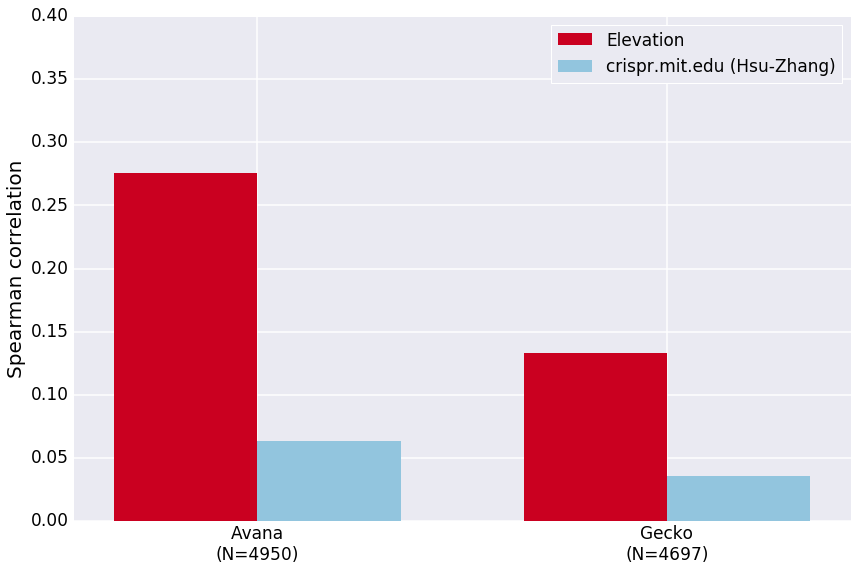

In [86]:
def get_stars(pv):
    if pv <= 1e-20:
        return "******"
    if pv <= 1e-10:
        return "*****"
    if pv <= 1e-5:
        return "****"
    if pv <= 0.01:
        return "***"
    if pv <= 0.025:
        return "**"
    if pv <= 0.05:
        return "*"
    else:
        return ""


methods_colors_agg = {'Broad website (CFD)': '#92c5de',
                     'crispr.mit.edu (Hsu-Zhang)':  '#92c5de',
                     'CCTOP': "#0571b0",
                     'Elevation': '#ca0020',
                     'Elevation-naive': '#92c5de'}

avana = {'Elevation': 0.276,
         'crispr.mit.edu (Hsu-Zhang)': 0.063}

gecko = {'Elevation': 0.133,
         'crispr.mit.edu (Hsu-Zhang)':0.036}

pv = {'gecko': 7.32747196253e-15,
      'avana': 1e-30} # Steiger returns 0.0, so putting this at machine precision

stars = {'gecko': get_stars(pv['gecko']),
        'avana': get_stars(pv['avana'])}

plt.figure(figsize=(12, 8))
width=0.7/len(avana.keys())
ind = 0
for i, n in enumerate(['Elevation', 'crispr.mit.edu (Hsu-Zhang)']):
    plt.bar(ind+(width*i), avana[n], width, color=methods_colors_agg[n], label=n, edgecolor='none')
    plt.bar(ind+1+(width*i), gecko[n], width, color=methods_colors_agg[n], edgecolor='none')

    

xpos = np.array([0, 1])+width*0.5+width/2.
ypos = avana['Elevation']
#plt.text(xpos[0]-0.07, ypos+0.05, stars['avana'], fontsize=20)
ypos = gecko['Elevation']
#plt.text(xpos[1]-0.07, ypos+0.05, stars['gecko'], fontsize=20)    

plt.xlim(-0.1, 1.8)
plt.ylim(0.0, 0.4)
plt.legend(loc=0)
plt.ylabel('Spearman correlation')
plt.xticks(np.array([0, 1])+width*0.5+width/2., ['Avana\n(N=4950)', 'Gecko\n(N=4697)'])
plt.tight_layout()

ax = plt.gca()
ax.patch.set_facecolor(background_color)
plt.grid(color='#ffffff', linestyle='-', linewidth=1.5)
ax.set_axisbelow(True)
a = ax.get_xgridlines()

# legend
plt.legend(loc=0)
lh = ax.get_legend()
lh.legendPatch.set_facecolor(background_color)

plt.savefig('plots/aggregation_performance.pdf')

In [93]:
with open('base_CFDfeat_predictions.pkl', 'rb') as f:
    preds_guideseq_cfd_feat, individual_mut_pred_roc_cfd_feat = pickle.load(f)

In [95]:
with open('base_classifier_predictions.pkl', 'rb') as f:
    preds_guideseq_class, individual_mut_pred_roc_class = pickle.load(f)

In [116]:
pred_roc_cfd_feat = pp.stacked_predictions(roc_data, individual_mut_pred_roc_cfd_feat, learn_options=learn_options, 
                                       guideseq_data=guideseq_data,
                                       preds_guideseq=preds_guideseq_cfd_feat, 
                                       prob_calibration_model=None,#calibration_models,
                                       models=['product', 'CFD', 'HsuZhang', 'linear-raw-stacker', 'ensemble'],
                                       return_model=False)

/mnt/projects_drive/projects/CRISPR/code/elevation/elevation/prediction_pipeline.py:354: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ind_keep[ind_zero[::ind_zero.shape[0]/float(ind_keep.sum())]] = True


In [117]:
pred_roc_class = pp.stacked_predictions(roc_data, individual_mut_pred_roc_class, learn_options=learn_options, 
                                       guideseq_data=guideseq_data,
                                       preds_guideseq=preds_guideseq_class, 
                                       prob_calibration_model=None,#calibration_models,
                                       models=['product', 'CFD', 'HsuZhang', 'linear-raw-stacker', 'ensemble'],
                                       return_model=False)

In [135]:
pred_roc_base_models = {}
pred_roc_base_models['elevation'] = pred_roc_calibrated['linear-raw-stacker'].copy()
pred_roc_base_models['CCTOP'] = pred_roc_calibrated['CCTOP'].copy()
pred_roc_base_models['elevation-product'] = pred_roc_calibrated['product'].copy()
pred_roc_base_models['elevation-classifier'] = pred_roc_class['product'].copy()
pred_roc_base_models['elevation-CFDfeat'] = pred_roc_cfd_feat['product'].copy()

elevation-classifier
elevation-CFDfeat
elevation
CCTOP


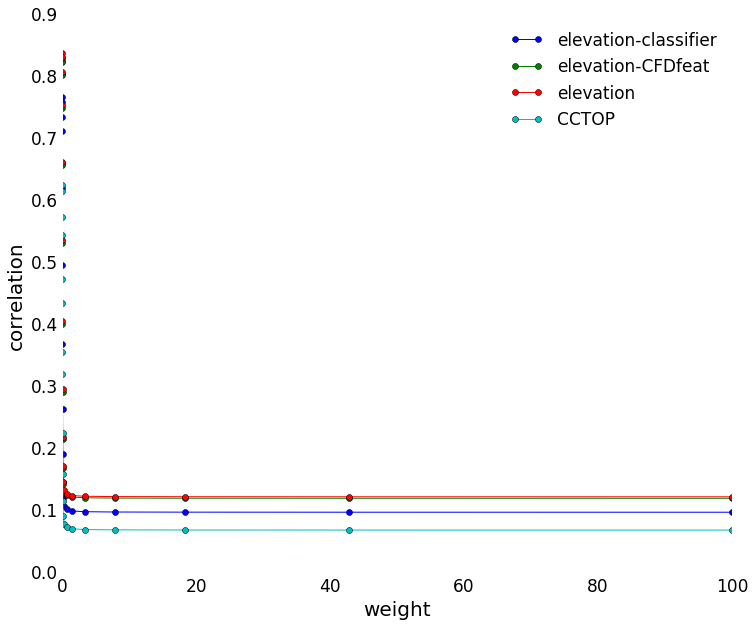

In [136]:
roc_results_base_models = pp.plot_spearman_with_different_weights(pred_roc_base_models, roc_Y_vals.values.flatten(), 
                                                      weights=np.logspace(np.log10(0.00001), np.log10(100), 20))

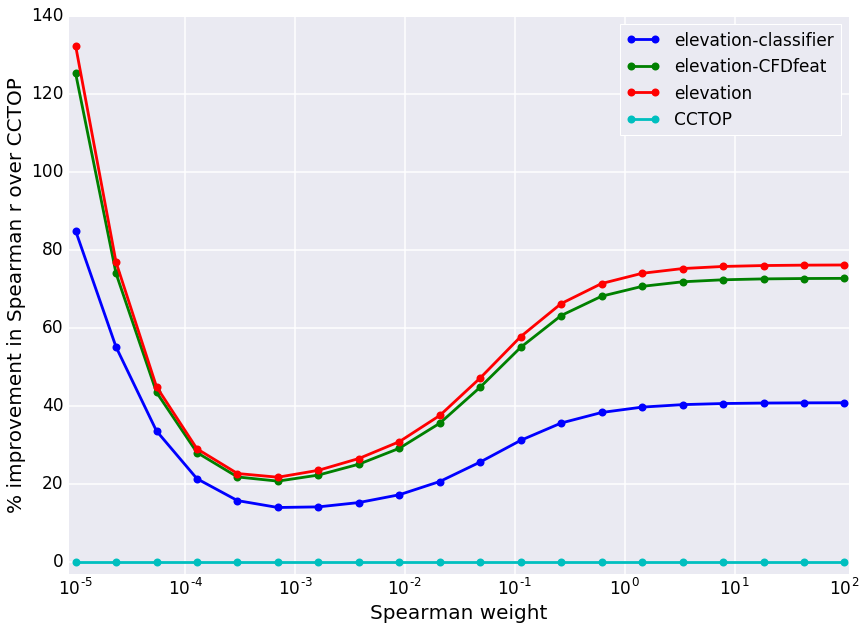

In [138]:
fig = plt.figure(figsize=(14, 10))

x = np.logspace(np.log10(0.00001), np.log10(100), 20)
for m in roc_results_base_models.keys():
    plt.plot(x, ((np.array(roc_results_base_models[m]) -np.array(roc_results_base_models['CCTOP']))/np.array(roc_results_base_models['CCTOP']))*100., 'o-', 
            markeredgewidth=0.0, linewidth=2.8, markersize=8, label=m)
plt.xscale('log')

# background color
ax = plt.gca()
ax.patch.set_facecolor(background_color)

# grid
plt.grid(color='#ffffff', linestyle='-', linewidth=1.5)
ax.set_axisbelow(True)
a = ax.get_xgridlines()
a[2].set_color(background_color)
a[-1].set_color(background_color)


# legend
plt.legend(loc=0)
lh = ax.get_legend()
lh.legendPatch.set_facecolor(background_color)


plt.ylim(-3., 140)
x_lims = plt.xlim()
plt.xlim((8.5e-6, 1.10*x_lims[1]))

plt.ylabel('% improvement in Spearman r over CCTOP')
plt.xlabel('Spearman weight')
#plt.savefig('plots/improvement_over_CCTOP_Haeussler.pdf')
# plt.title("Haeussler minus GUIDE-Seq")

In [111]:
pred_guideseq_hmg_feat = pp.stacked_predictions(guideseq_data, preds_guideseq_cfd_feat, guideseq_data=hmg,
                                                preds_guideseq=individual_mut_pred_roc_cfd_feat,
                                                prob_calibration_model=None,
                                                learn_options=learn_options,
                                                models=['product', 'CFD', 'HsuZhang', 'linear-raw-stacker', 'ensemble'],
                                                return_model=False,
                                                )

In [112]:
pred_guideseq_hmg_class = pp.stacked_predictions(guideseq_data, preds_guideseq_class, guideseq_data=hmg,
                                                preds_guideseq=individual_mut_pred_roc_class,
                                                prob_calibration_model=None,
                                                learn_options=learn_options,
                                                models=['product'],
                                                return_model=False,
                                                )

In [113]:
pred_hmg_base_models = {}
pred_hmg_base_models['elevation'] = pred_guideseq_hmg['product'].copy()
pred_hmg_base_models['CCTOP'] = pred_guideseq_hmg['CCTOP'].copy()
pred_hmg_base_models['elevation-classifier'] = pred_guideseq_hmg_class['product'].copy()
pred_hmg_base_models['elevation-CFDfeat'] = pred_guideseq_hmg_feat['product'].copy()

elevation-classifier
elevation-CFDfeat
elevation
CCTOP


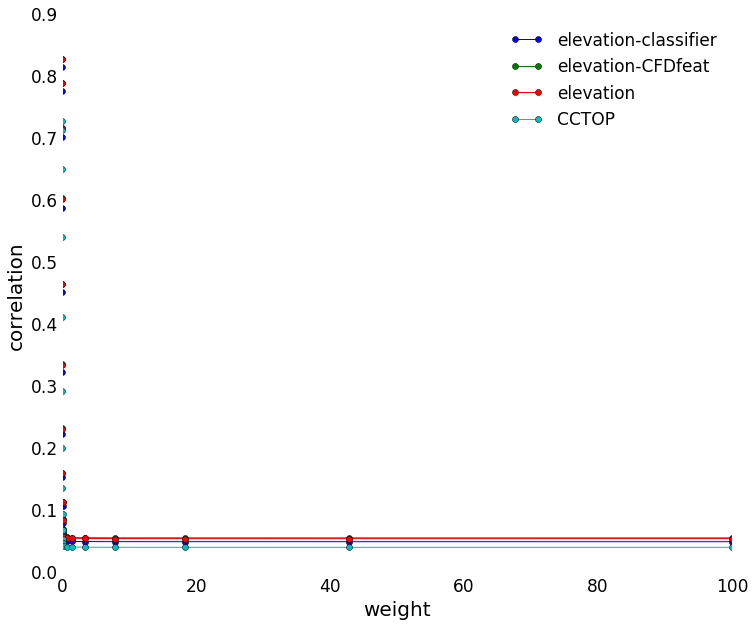

In [114]:
gs_results_hmg_base_models = pp.plot_spearman_with_different_weights(pred_hmg_base_models, guideseq_data['GUIDE-SEQ Reads'].values.flatten(), 
                                                      weights=np.logspace(np.log10(0.00001), np.log10(100), 20))

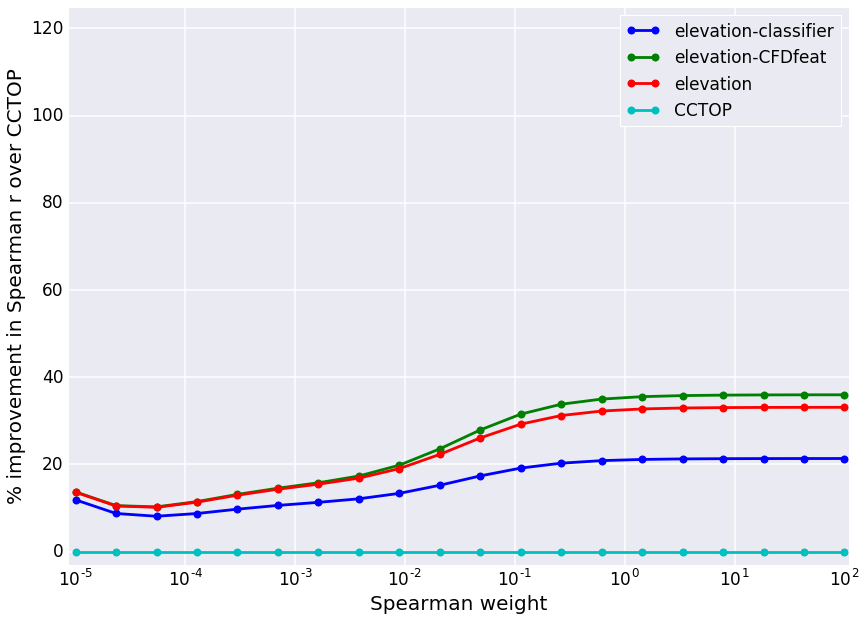

In [115]:
fig = plt.figure(figsize=(14, 10))

x = np.logspace(np.log10(0.00001), np.log10(100), 20)
for m in roc_results_base_models.keys():
    plt.plot(x, ((np.array(gs_results_hmg_base_models[m]) -np.array(gs_results_hmg_base_models['CCTOP']))/np.array(gs_results_hmg_base_models['CCTOP']))*100., 'o-', 
            markeredgewidth=0.0, linewidth=2.8, markersize=8, label=m)
plt.xscale('log')

# background color
ax = plt.gca()
ax.patch.set_facecolor(background_color)

# grid
plt.grid(color='#ffffff', linestyle='-', linewidth=1.5)
ax.set_axisbelow(True)
a = ax.get_xgridlines()
a[2].set_color(background_color)
a[-1].set_color(background_color)


# legend
plt.legend(loc=0)
lh = ax.get_legend()
lh.legendPatch.set_facecolor(background_color)


plt.ylim(-3., 125)
x_lims = plt.xlim()
plt.xlim((8.5e-6, 1.10*x_lims[1]))

plt.ylabel('% improvement in Spearman r over CCTOP')
plt.xlabel('Spearman weight')